# Fraud Detection Models

This notebook implements baseline machine learning models to detect fraudulent transactions.
The focus is on correct evaluation metrics suitable for highly imbalanced financial data.


In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
df = pd.read_csv("C:/Users/vikas/Desktop/SentinelPay/data/creditcard.csv")

X = df.drop("Class", axis=1)
y = df["Class"]


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[['Time', 'Amount']] = scaler.fit_transform(
    X_train[['Time', 'Amount']]
)

X_test[['Time', 'Amount']] = scaler.transform(
    X_test[['Time', 'Amount']]
)


In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



Two different approaches are evaluated:

1. **Random Forest** – Supervised learning using labeled data
2. **Isolation Forest** – Unsupervised anomaly detection

This comparison reflects real-world fraud detection systems.


In [13]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [14]:
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



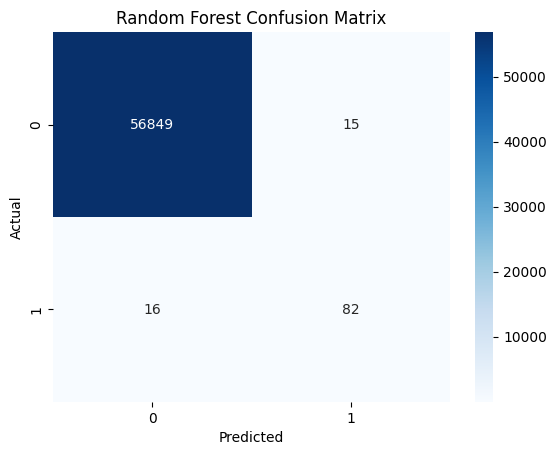

In [15]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


- Precision is critical to minimize false fraud alerts
- Recall is important to avoid missing fraudulent transactions
- Accuracy is not a reliable metric due to class imbalance


In [16]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.0017,
    random_state=42
)

iso_forest.fit(X_train)


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.0017
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [17]:
iso_preds = iso_forest.predict(X_test)
iso_preds = np.where(iso_preds == -1, 1, 0)

print(classification_report(y_test, iso_preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.34      0.32        98

    accuracy                           1.00     56962
   macro avg       0.66      0.67      0.66     56962
weighted avg       1.00      1.00      1.00     56962



### Model Comparison

- Random Forest performs better due to labeled training data
- Isolation Forest is useful when labeled fraud data is scarce
- Hybrid approaches are often used in real FinTech systems


### Summary

- Implemented supervised and unsupervised fraud detection models
- Used appropriate evaluation metrics for imbalanced data
- Demonstrated trade-offs between detection accuracy and false positives


## Threshold Tuning & Business Evaluation

In real-world fraud detection systems, model probabilities must be converted into decisions
using business-aware thresholds. A lower threshold increases fraud capture but may also
increase false alerts.


In [18]:
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]


In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)


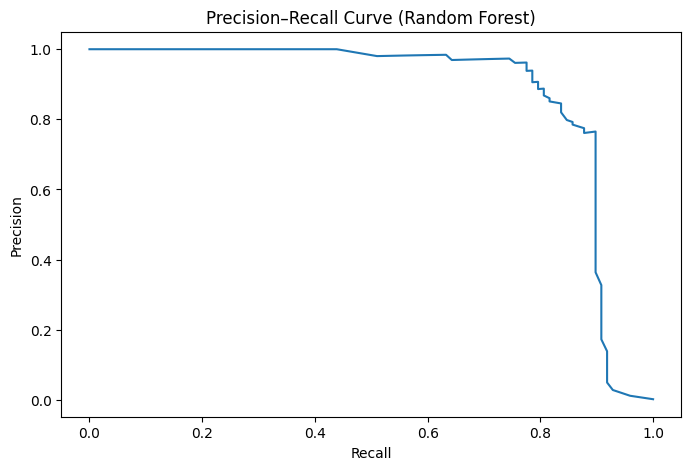

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.show()


In [21]:
def evaluate_threshold(threshold):
    y_pred_custom = (y_proba_rf >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(confusion_matrix(y_test, y_pred_custom))
    print(classification_report(y_test, y_pred_custom))

# Try business-relevant thresholds
for t in [0.1, 0.2, 0.3, 0.5]:
    evaluate_threshold(t)



Threshold: 0.1
[[56637   227]
 [    9    89]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.28      0.91      0.43        98

    accuracy                           1.00     56962
   macro avg       0.64      0.95      0.71     56962
weighted avg       1.00      1.00      1.00     56962


Threshold: 0.2
[[56803    61]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.90      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.95      0.86     56962
weighted avg       1.00      1.00      1.00     56962


Threshold: 0.3
[[56832    32]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.90      0.81        98

    accuracy                           1.

### Business Interpretation

- Lower thresholds increase recall but also increase false positives
- Higher thresholds reduce customer friction but may miss fraud
- Threshold selection depends on risk appetite and transaction value


In [22]:
roc_score = roc_auc_score(y_test, y_proba_rf)
print("ROC AUC Score:", roc_score)


ROC AUC Score: 0.9731024901519414


### Final Takeaways

- Fraud detection is a decision optimization problem, not just classification
- Precision–Recall trade-offs must be aligned with business goals
- Threshold tuning is essential in production-grade systems


## Explainable AI (XAI)

In financial systems, model decisions must be transparent and explainable.
This section analyzes which features contribute most to fraud predictions.


In [23]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
14,V14,0.195592
10,V10,0.110475
4,V4,0.106104
12,V12,0.095099
17,V17,0.085020
3,V3,0.060413
11,V11,0.056353
16,V16,0.043779
2,V2,0.036997
9,V9,0.026209


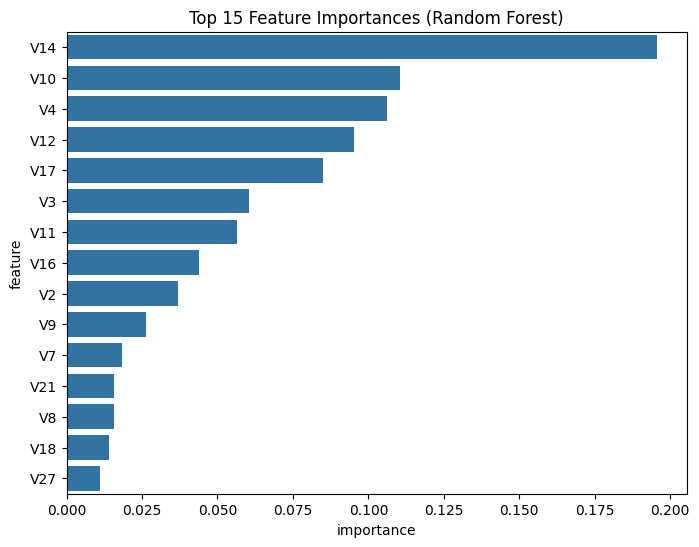

In [24]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x="importance",
    y="feature",
    data=feature_importance.head(15)
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


### Feature Importance Interpretation

- Random Forest provides built-in interpretability
- PCA-based features dominate due to anonymization
- Transaction timing and amount still play a role
- Feature importance supports model transparency


In [25]:
import shap

shap.initjs()


In [34]:
import shap

# Sample for performance
sample_X = X_train.sample(1000, random_state=42)

# Use the modern unified explainer
explainer = shap.Explainer(rf_model, sample_X)

# Get SHAP explanation object
shap_values = explainer(sample_X)


 99%|===================| 1977/2000 [00:42<00:00]        

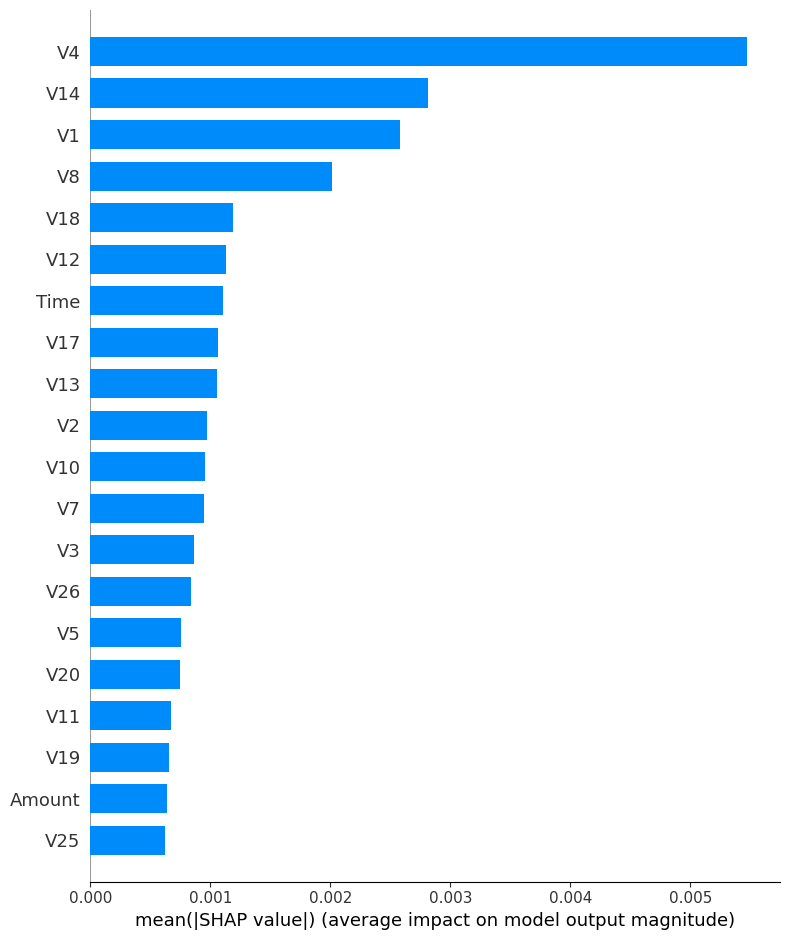

In [35]:
shap.summary_plot(
    shap_values.values[:, :, 1],
    sample_X,
    plot_type="bar"
)


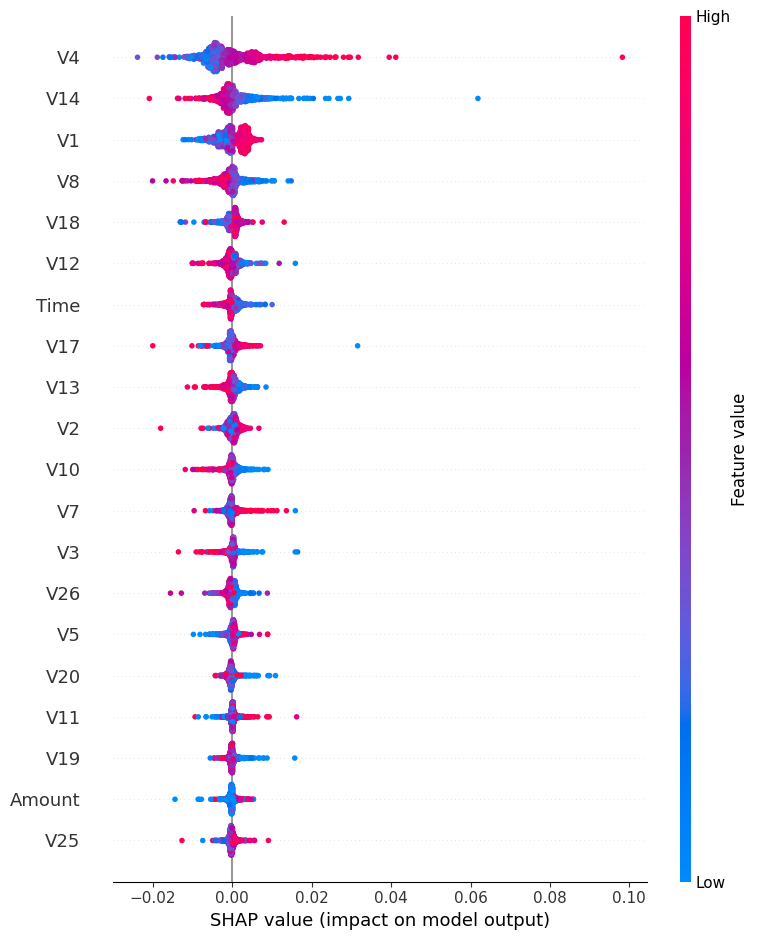

In [36]:
shap.summary_plot(
    shap_values.values[:, :, 1],
    sample_X
)
